In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

# New section

In [ ]:
# Set parameters
num_workers = 0 # this is how many subprocesses will be running to load the data
batch_size = 20 # this is how many samples (images) will be in a batch

# Convert data to tensor and download datasets
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create validation set
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,num_workers = num_workers)

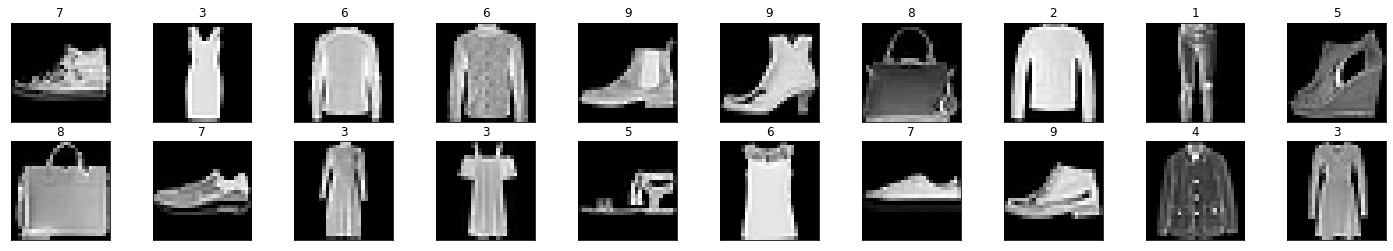

In [ ]:
# Visualise a single batch of images and their labels
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [ ]:
# Create MLP architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        hidden_1 = 512 # nodes per layer
        hidden_2 = 512

        self.fc1 = nn.Linear(28*28, 512) # the image dimension is 28x28 so input needs to be 28*28
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,10) # we have 10 classes so output needs to be 10

        self.droput = nn.Dropout(0.2) # 20% of nodes will drop out

    def forward(self,x):
        x = x.view(-1,28*28) # input is flattened
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = self.fc3(x)
        return x

In [ ]:
# Initialise model
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [ ]:
# Define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001)

In [ ]:
n_epochs = 50

# Track epochs,loss and accuracy
valid_loss_min = np.Inf

epoch = 1
epoch_track = []
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0

    train_acc = 0

    curr_epoch = epoch + 1
    epoch_track.append(curr_epoch)

    # Train
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)
        train_correct = np.squeeze(pred.eq(label.data.view_as(pred)))
        train_acc = torch.count_nonzero(train_correct) / train_correct.size(dim=0)

    # Validate
    model.eval()
    for data,label in valid_loader:
        # skip optimisation
        output = model(data)
        loss = criterion(output,label)
        valid_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)
        valid_correct = np.squeeze(pred.eq(label.data.view_as(pred)))
        valid_acc = torch.count_nonzero(valid_correct) / valid_correct.size(dim=0)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        train_loss,
        valid_loss
        ))

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.108631 	Validation Loss: 1.759747
Validation loss decreased (inf --> 1.759747).  Saving model ...
Epoch: 2 	Training Loss: 1.398431 	Validation Loss: 1.100182
Validation loss decreased (1.759747 --> 1.100182).  Saving model ...
Epoch: 3 	Training Loss: 1.006056 	Validation Loss: 0.881719
Validation loss decreased (1.100182 --> 0.881719).  Saving model ...
Epoch: 4 	Training Loss: 0.862057 	Validation Loss: 0.784608
Validation loss decreased (0.881719 --> 0.784608).  Saving model ...
Epoch: 5 	Training Loss: 0.790492 	Validation Loss: 0.726554
Validation loss decreased (0.784608 --> 0.726554).  Saving model ...
Epoch: 6 	Training Loss: 0.738069 	Validation Loss: 0.685758
Validation loss decreased (0.726554 --> 0.685758).  Saving model ...
Epoch: 7 	Training Loss: 0.702234 	Validation Loss: 0.649803
Validation loss decreased (0.685758 --> 0.649803).  Saving model ...
Epoch: 8 	Training Loss: 0.672473 	Validation Loss: 0.621809
Validation loss decreased (0.64980

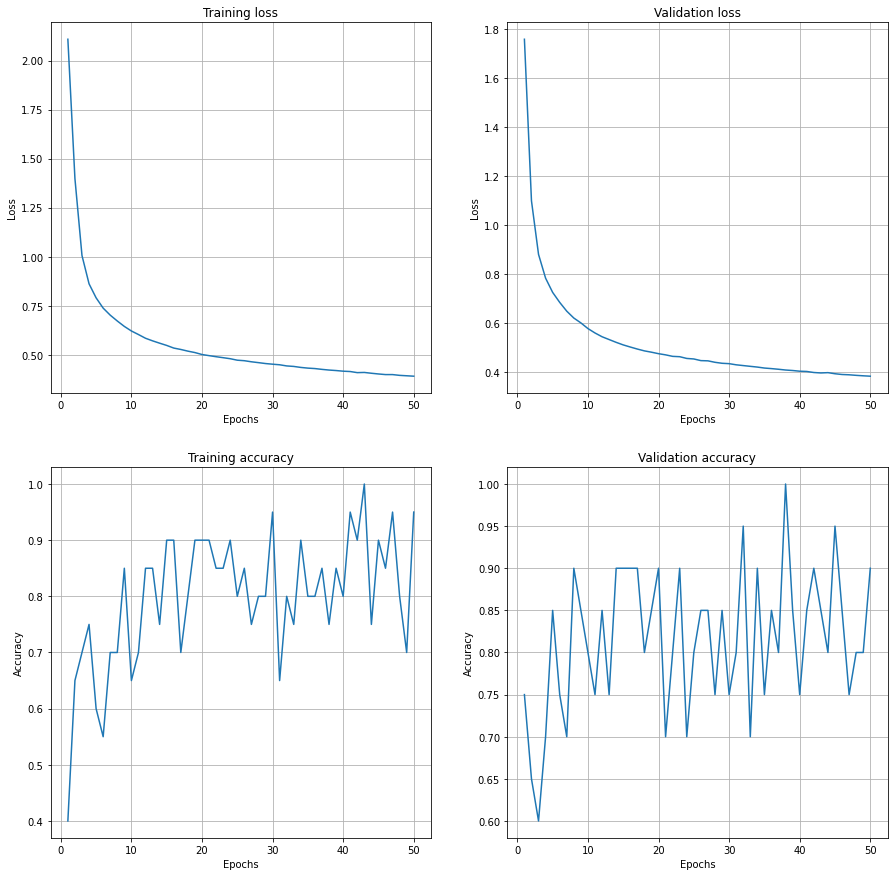

In [ ]:
# Plot loss and accuracy
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

axs[0,0].plot(epoch_track, train_losses)
axs[0,0].set_title("Training loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss")
axs[0,1].plot(epoch_track, valid_losses)
axs[0,1].set_title("Validation loss")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss")
axs[1,0].plot(epoch_track, train_accs)
axs[1,0].set_title("Training accuracy")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Accuracy")
axs[1,1].plot(epoch_track, valid_accs)
axs[1,1].set_title("Validation accuracy")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Accuracy")

axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
# Testing
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.412364

Test Accuracy of     0: 83% (836/1000)
Test Accuracy of     1: 95% (954/1000)
Test Accuracy of     2: 75% (757/1000)
Test Accuracy of     3: 87% (877/1000)
Test Accuracy of     4: 79% (794/1000)
Test Accuracy of     5: 91% (916/1000)
Test Accuracy of     6: 55% (552/1000)
Test Accuracy of     7: 92% (920/1000)
Test Accuracy of     8: 95% (951/1000)
Test Accuracy of     9: 95% (956/1000)

Test Accuracy (Overall): 85% (8513/10000)


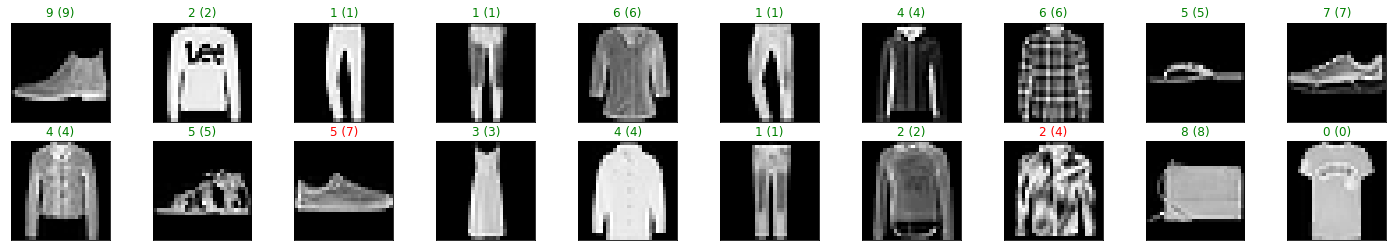

In [ ]:
# View correct vs proposed labels on test batch
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))